In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
import xgboost as xgb
import pandas as pd 
import random
import joblib
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern,ConstantKernel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct 
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import mean_squared_error

In [2]:
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sheet_names = file.sheet_names

 
data_frame = pd.read_excel(file, sheet_name=sheet_names[0], engine='openpyxl')

 
temperature = data_frame.loc[data_frame["Parameter"] == "Annealing temperature"].to_numpy()
temperature = temperature[2, 2:]  

 
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0], 1))
devices = devices[2:]   

 
time_series_df = pd.read_excel(file, sheet_name=sheet_names[-1], engine='openpyxl')

 
time_series_df = time_series_df.drop(index=[0])

 
time = time_series_df.iloc[:, 0]
 

time_series_1_sun = []
for i in range(temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:, 3 + i * 3])

time_series_1_sun = np.array(time_series_1_sun)

 
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')
irradiance = outdoor_conditions['irradiance']
rh = outdoor_conditions['rh']
outdoor_temperature = outdoor_conditions['outdoor_temperature']
outdoor_condition_time = outdoor_conditions['time']

 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())

 
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep='\t')
outdoor_panels_power = []

 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])

outdoor_panels_power = np.array(outdoor_panels_power)
 

time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_sun = np.pad(
    time_series_1_sun, ((0, 0), (0, outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])), mode='edge')
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0], time_series_1_sun.shape[1], 1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0], outdoor_panels_power.shape[1], 1)))
time_series_1_sun_shape

(24, 4001)

In [3]:
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     


 
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0  
        b += 1

 
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
 
 

In [4]:
def exponential_smoothing(series, alpha):
    smoothed_series = [series[0]]   
    for i in range(1, len(series)):
        smoothed_value = alpha * series[i] + (1 - alpha) * smoothed_series[-1]
        smoothed_series.append(smoothed_value)
    return np.array(smoothed_series)

alpha = 0.1   
for i in range (time_series_1_sun_average.shape[0]):
  time_series_1_sun_average[i] = time_series_1_sun_average[i] * -1
  time_series_1_sun_average[i] = exponential_smoothing(time_series_1_sun_average[i], 0.1)
  outdoor_panels_power_average[i] = exponential_smoothing(outdoor_panels_power_average[i], 0.7)
all_new_features = np.concatenate((time_series_1_sun_average , outdoor_conditions_stacked[:, :, [1,2,3,4]]), axis=2)
print(time_series_1_sun_average)

[[[4.014015  ]
  [4.5836045 ]
  [5.03449905]
  ...
  [4.958105  ]
  [4.958105  ]
  [4.958105  ]]

 [[3.796585  ]
  [4.4534625 ]
  [5.02160525]
  ...
  [7.10491   ]
  [7.10491   ]
  [7.10491   ]]

 [[4.112935  ]
  [4.638087  ]
  [5.1068628 ]
  ...
  [4.98345   ]
  [4.98345   ]
  [4.98345   ]]

 ...

 [[4.414445  ]
  [5.0604605 ]
  [5.63430445]
  ...
  [7.534     ]
  [7.534     ]
  [7.534     ]]

 [[3.61228   ]
  [4.348898  ]
  [5.0017842 ]
  ...
  [7.67303   ]
  [7.67303   ]
  [7.67303   ]]

 [[2.721955  ]
  [3.599814  ]
  [4.3853846 ]
  ...
  [7.86305   ]
  [7.86305   ]
  [7.86305   ]]]


In [5]:
 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


In [7]:
num_samples = all_new_features.shape[0]
all_new_features_reshaped = all_new_features.reshape(num_samples, -1)
outdoor_panels_power_average_reshaped = outdoor_panels_power_average.reshape(num_samples, -1)
 
num_folds = 12
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 4794))
y_pred2=np.zeros(( 1, 4794))
predictions1 = np.zeros((12, 1, 4794))
test1= np.zeros((12, 1, 4794))
predictions2 = np.zeros((12, 1, 4794))
test2 = np.zeros((12, 1, 4794))
 
 
for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]
    X_train, X_test = all_new_features_reshaped [train_index], all_new_features_reshaped [test_index]
    y_train, y_test = outdoor_panels_power_average_reshaped[train_index], outdoor_panels_power_average_reshaped[test_index]
    scaler = StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    param_space = {
        'kernel': Categorical(['linear', 'rbf', 'poly']),
        'alpha': Real(0.001, 20.0, prior='log-uniform'),   
        'gamma': Real(0.0001, 20.0, prior='log-uniform'),   
        'degree': Integer(1, 5),   
        'coef0': Real(-2.0, 2.0),  
    }

  
    def objective_function(params):
        kernel = params[0]
        alpha = params[1]
        gamma = params[2]
        degree = params[3]
        coef0 = params[4]
        krr_model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, degree=degree, coef0=coef0)
        krr_model.fit(X_train, y_train)

        y_pred = krr_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

     
    result = gp_minimize(
        objective_function,
        dimensions=list(param_space.values()),
        n_calls=100,  
        random_state=42,
        verbose=0
    )

  
    best_params = dict(zip(param_space.keys(), result.x))
    print("Best Hyperparameters for Fold {}: {}".format(fold + 1, best_params))
    best_krr_model = KernelRidge(**best_params)
    best_krr_model.fit(X_train, y_train)
    r_squared =  best_krr_model.score(X_train, y_train)
    training_error = 1 - r_squared
    print((X_test[0].reshape(1, -1)) .shape)
    y_pred1 = best_krr_model.predict(X_test[0].reshape(1, -1))
    y_pred2 = best_krr_model.predict(X_test[1].reshape(1, -1))
    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    test1[fold] = y_test[0]
    test2[fold] = y_test[1]
    error1 = mean_squared_error(y_test[0].reshape(1, -1), y_pred1)
    error2= mean_squared_error(y_test[1].reshape(1, -1), y_pred2)
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))

    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break

average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


KeyboardInterrupt: 

IndexError: list index out of range

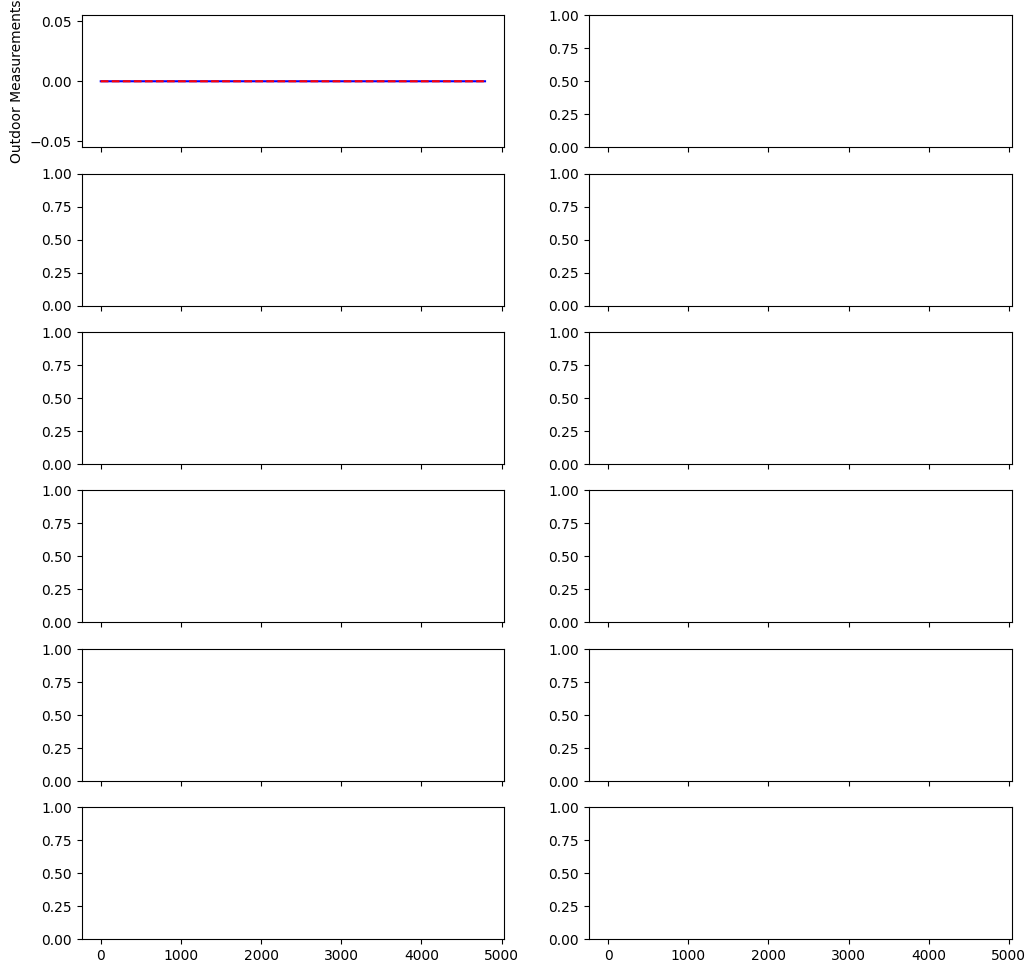

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(0, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(0, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2
axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction for 1.0 Sun Using Kernel Ridge Regression\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('1.0 sun using krr.png')
plt.show()

In [9]:

hyperparameters_list = [
    {'kernel': 0, 'alpha': 2.5022367786542192, 'gamma': 0.0001, 'degree': 1, 'coef0': 0.5995884693897389},
    {'kernel': 1, 'alpha': 0.0010003129042078802, 'gamma': 20.0, 'degree': 1, 'coef0': -0.05564441912892182},
    {'kernel': 1, 'alpha': 20.0, 'gamma': 0.00033450686310848517, 'degree': 2, 'coef0': 2.0},
    {'kernel': 0, 'alpha': 0.06739197266582012, 'gamma': 0.0012656248464729195, 'degree': 3, 'coef0': -1.8747468301777657},
    {'kernel': 1, 'alpha': 0.4273056056637292, 'gamma': 0.00010900808140765598, 'degree': 1, 'coef0': 0.09909864103355703},
    {'kernel': 1, 'alpha': 0.011830934274398503, 'gamma': 0.0001, 'degree': 1, 'coef0': 0.5551439189684357}
]


sum_hyperparameters = {
    'kernel': 0,
    'alpha': 0,
    'gamma': 0,
    'degree': 0,
    'coef0': 0
}


for hyperparameters in hyperparameters_list:
    for key, value in hyperparameters.items():
        sum_hyperparameters[key] += value

num_models = len(hyperparameters_list)
average_hyperparameters = {key: value / num_models for key, value in sum_hyperparameters.items()}
 
scaler=MinMaxScaler()
all_new_features_reshaped=scaler.fit_transform(all_new_features_reshaped)
print("Average Hyperparameters:")
print(average_hyperparameters)
krr_model = KernelRidge(kernel= 'poly', alpha= 3.8349609340270625, gamma= 3.3336515232984976,degree=0,  coef0= 0.2205732966808407)
krr_model.fit(all_new_features_reshaped,outdoor_panels_power_average_reshaped)
r_squared = krr_model.score(all_new_features_reshaped, outdoor_panels_power_average_reshaped)
training_error = 1 - r_squared
print(f"Training Error: {training_error:.4f}")


Average Hyperparameters:
{'kernel': 0.6666666666666666, 'alpha': 3.8349609340270625, 'gamma': 3.3336515232984976, 'degree': 1.5, 'coef0': 0.2205732966808407}
Training Error: 1.1042


In [11]:
model_filename = 'krr_model.pkl'
joblib.dump(krr_model, model_filename)


['krr_model.pkl']